In [1]:
from IPython.display import HTML, display, Image
HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

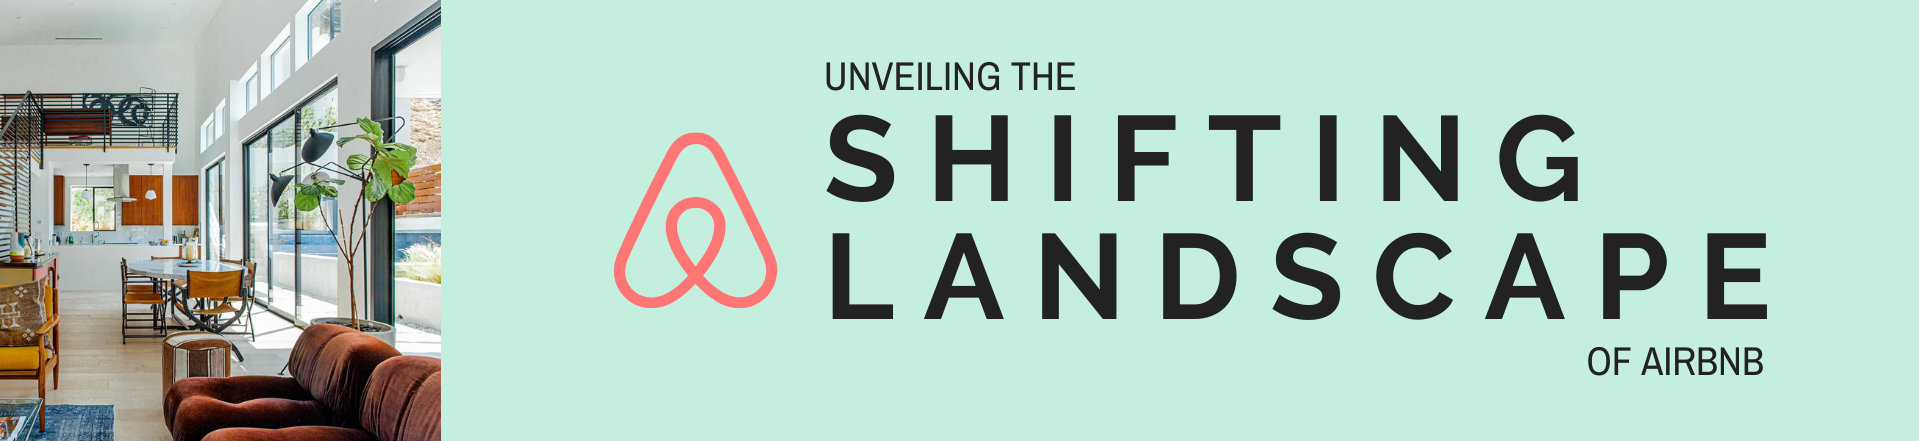

# <center> Understanding Supply, Demand, and Pricing Dynamics </center>

In [2]:
# General Imports
import numpy as np
import pandas as pd

# For Plots
import matplotlib.pyplot as plt
import seaborn as sns
import io
from matplotlib.ticker import EngFormatter
%matplotlib inline

# set global plotting parameters
custom_sns_params = {'lines.linewidth': 1.5, 'font.size': 11,
                     'axes.titlesize': 12, 'axes.labelsize': 12,
                     'xtick.labelsize': 11, 'ytick.labelsize': 10,
                     'legend.fontsize': 12, 'legend.fancybox': True,
                     'figure.figsize': (16, 6), 'figure.dpi': 120,
                     'axes.spines.right': False, 'axes.spines.top': False}

sns.set_theme('notebook', style='ticks', rc=custom_sns_params)
colors = ['#FF5A60', '#FFA5A9', '#FFD1D3', '#7AB8AC', '#A0D2C7', '#C4EEDE',
          '#F5F5F5', '#CCCCCC', '#FF8A67', '#FFBDA3', '#67C2FF', '#A3E1FF']
custom_palette = sns.blend_palette(colors, n_colors=12)
sns.set_palette(custom_palette)

# For PySpark
import warnings
warnings.filterwarnings("ignore")
import pyspark.pandas as ps
from pyspark.sql import SparkSession

# Session Builder
spark = (SparkSession
         .builder
         .master('local[*]')
         .config('spark.sql.execution.arrow.pyspark.enabled', 'true')
         .getOrCreate())
spark.sparkContext.setLogLevel('OFF')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-twoev130 because the default path (/home/mmenorca/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/16 09:16:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/16 09:16:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


***
<h1 style="color: #FF5A60"><b>I. Executive Summary</b></h1>

In the recent years, the rental economy [1] experienced a significant transformation influenced by dynamic factors like the COVID-19 pandemic, evolving travel patterns and customer preference, and shifting economic conditions. Understanding the trends of this ever-changing market is crucial for stakeholders in the short- and long-term rental market [2]. Through a comprehensive analysis of the `Inside Airbnb` data, this project aims to uncover valuable insights into trends on pricing, availability, and demand. By delving into these key factors, the project seeks to enable travelers, hosts, and other industry stakeholders with the necessary information to make informed decisions.

The project consists of three phases: data preprocessing, data transformation, and Exploratory Data Analysis (EDA). The data preprocessing phase address various data quality issues, including handling malformed files, correcting data types, and reformatting the dataset to ensure reliability for analysis. Parquet files were utilized for more efficient processing given its columnar storage format. In the data transformation phase, data was aggregated and transformed to generate the necessary statistics for analysis. Finally, the EDA focused on analyzing global trends and conducting cross-country comparisons on pricing, availability, and demand of listings in Airbnb.

Results show insightful temporal trends affected by the COVID-19 pandemic and travel restrictions. Following the pandemic, a gradual recovery is observed, characterized by price increases and improved availability. Country-specific analysis highlights variations in pricing and popularity. The United States emerges as a high-demand market with correspondingly higher prices. South Africa exhibits higher prices but lower popularity, while Switzerland, Ireland, Japan, and Belgium show promise as emerging travel destinations with lower prices and moderate popularity. Spain, the United Kingdom, Italy, and France stand out with a combination of high popularity and relatively lower prices, making them attractive options for budget-conscious travelers.

Ultimately, this project uncovers the shifting dynamics of the rental market by providing an understanding into supply, demand, and pricing dynamics. The findings highlight the impact of external factors such as the pandemic and travel restrictions on pricing and availability trends. By understanding these dynamics, stakeholders can make informed decisions, adapt to evolving market trends, and optimize their strategies in the hospitality industry.

***
<h1 style="color: #FF5A60"><b>II. Problem Statement</b></h1>

This study aims to analyze the changes in Airbnb prices, availability, and demand from 2019 to 2022 and explore variations in these metrics across different countries. The problems to solve are stated as follows:

1. How did Airbnb prices, availability, and demand change over the recent years?
2. How do prices, availability, and demand vary by country?

By addressing these questions, this analysis will provide insight into the temporal trends and cross-country variations of the Airbnb market dynamics, enabling a comprehensive understanding of the evolving rental economy.

***
<h1 style="color: #FF5A60"><b>III. Motivation</b></h1>

The rise of Airbnb has disrupted the traditional travel and hospitality industries, providing travelers with unique and affordable accommodations while enabling hosts to earn extra income by renting out their homes. However, as the number of listings on the platform continues to grow, both hosts and travelers face challenges in optimizing their listings and finding the best deals [3]. 

By analyzing the Inside Airbnb dataset, we can gain valuable insights into the factors that influence the success of Airbnb listings, such as pricing, availability, and demand. This information can help both hosts and travelers make more informed decisions about their listings and bookings, while also identifying trends and opportunities in the market.

Ultimately, this study aims to improve the Airbnb experience for both hosts and travelers, providing a valuable resource for anyone looking to maximize their returns on investment or find the perfect accommodations for their next trip.

***
<h1 style="color: #FF5A60"><b>IV. Data Source</b></h1>

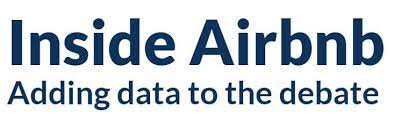

<center>Figure 1. Inside Airbnb Logo</center>

**Inside Airbnb Database**

This dataset is available in the jojie public dataset repository. It contains Listings. Below is a quick summary of the database contents.

Filepath: /mnt/data/public/insideairbnb

**Database Summary:**
- Listings data for various cities around the world on the Airbnb platform
- Includes information on location, property type, price, availability, and occupancy rates of Airbnb listings.
- Host data includes several properties managed, reviews, and response rates.
- Valuable resource for studying the impact of the sharing economy on urban housing markets and communities.
- Each City/State has its own detailed `Listings Data`, `Calendar Data`, `Review Data`, and `Neighborhood Data`.
- Created by Murray Cox to help understand the impact of Airbnb on local housing markets and communities.

**Original Data Source**

The dataset can be downloaded from the Inside Airbnb website: http://insideairbnb.com/get-the-data/

<h3>Calendar Dataset</h3>

Among the various datasets in the database, this project focuses on the calendar dataset which provides a detailed view of the availability and pricing for each Airbnb listing over time. It includes information on when each listing is available, how much it costs per night, and any minimum stay requirements.

</br>

<span style="font-size: 14px">
    <center><b>Table 1. Calendar Raw Data Description</b></center>
</span>

|<center>Variable Name</center>|<center>Data type</center>|<center>Variable Caterogy</center>|<center>Description</center>
|:--------------------|:------|:---|:---|
|listing_id           |integer |nominal    |Airbnb's unique identifier for the listing
|date                 |datetime|datetime   |The date in the listing's calendar
|available            |boolean |binary     |Whether the date is available for a booking
|price                |currency|continuous |The price listed for the day

</br>
To extract more meaningful insights, the raw data underwent a comprehensive processing phase where additional features were extracted from the listing data.


</br>
</br>

<span style="font-size: 14px">
    <center><b>Table 2. Calendar Final Data Description</b></center>
</span>

|<center>Variable Name</center>|<center>Data type</center>|<center>Variable Caterogy</center>|<center>Description</center>
|:--------------------|:------|:---|:---|
|listing_id           |integer |nominal    |Airbnb's unique identifier for the listing
|date                 |datetime|datetime   |The date in the listing's calendar
|available            |boolean |binary     |Whether the date is available for a booking
|price                |currency|continuous |The price listed for the day
|adjusted price       |currency|continuous |Reflects the true cost of each listing
|minimum_nights       |integer |continuous |Minimum number of night stay for the listing
|minimum_nights       |integer |continuous |Maximum number of night stays for the listing
|year                 |integer |ordinal    |The year corresponding to the date column.
|month                |string  |ordinal    |The month corresponding to the date column.
|dayofweek            |string  |ordinal    |The day of the week corresponding to the date column.
|country              |string  |nominal    |The country where the Airbnb is listed.

***
<h1 style="color: #FF5A60"><b>V. Methodology</b></h1>

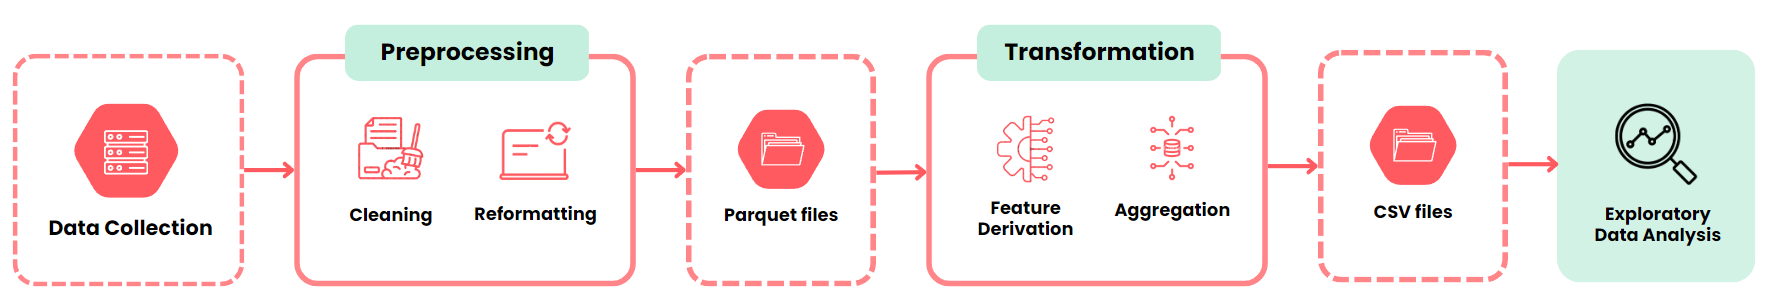

<center>Figure 2. Methodology Pipeline</center>

This project has 3 main phases: data preprocessing, data transformation, and Exploratory Data Analysis.

Due to some challenges encountered when reading the raw files directly, some data preprocessing steps had to be done. Some of the files in the dataset are malformed having unescaped characters or inconsistent delimiters which results in an error when read in bulk. Moreover, some of the features have the wrong data type (e.g., `price`: `object`) and have extra characters (',' or '.') making them unusable for transformation and analysis. Files within a year also range up to billions of rows which makes processing time slow and application of mathematical operations inefficient. Given this, the dataset was cleaned and reformatted first and was then converted into Parquet files for more efficient reading and transformation thanks to its columnar storage format allowing for more efficient compression and better query performance. The complete discussion of the steps done is detailed in a separate notebook, **bdcc2023_lab1_dataprep.ipynb**.

In the data transformation phase, aggregations were done to generate the statistics used for analysis and were then saved as CSV files for replicability and to avoid rerunning the operations every time. The complete discussion of the steps in this phase is detailed in a separate notebook, **bdcc2023_lab1_queries.ipynb**.

Finally, the information generated was used to analyze the global trends and cross-country comparisons in the pricing, availability, and demand of Airbnb listings.

***
<h1 style="color: #FF5A60"><b>VI. Data Exploration</b></h1>

To better understand how the platform operates, we can analyze several key metrics that help us to quantify supply, demand, and pricing dynamics.

**Assumptions:**
1. `Supply`can be measured by the number of entries in the calendar data, reflecting the availability of Airbnb listings throughout the year.
2. `Demand` can be measured as the number or percentage of unavailable listings in the calendar data, reflecting the level of competition among hosts and the potential for higher prices.
3. `Short-term` and `long-term` rentals can be distinguished based on the distribution of minimum and maximum nights required for each listing. For simplicity, we've defined `Short-term` stay as listings with a 7-day minimum stay at most. Otherwise, `Long-term`.
4. Pricing can be influenced by a variety of factors, including discounts and other promotional offers. An `adjusted price` metric can be used to reflect the true cost of each listing.
5. `Popularity` can be measured as the number of unique listings booked on Airbnb.

**Sample Data:**

<center>Table 3. Sample Final Data</center>

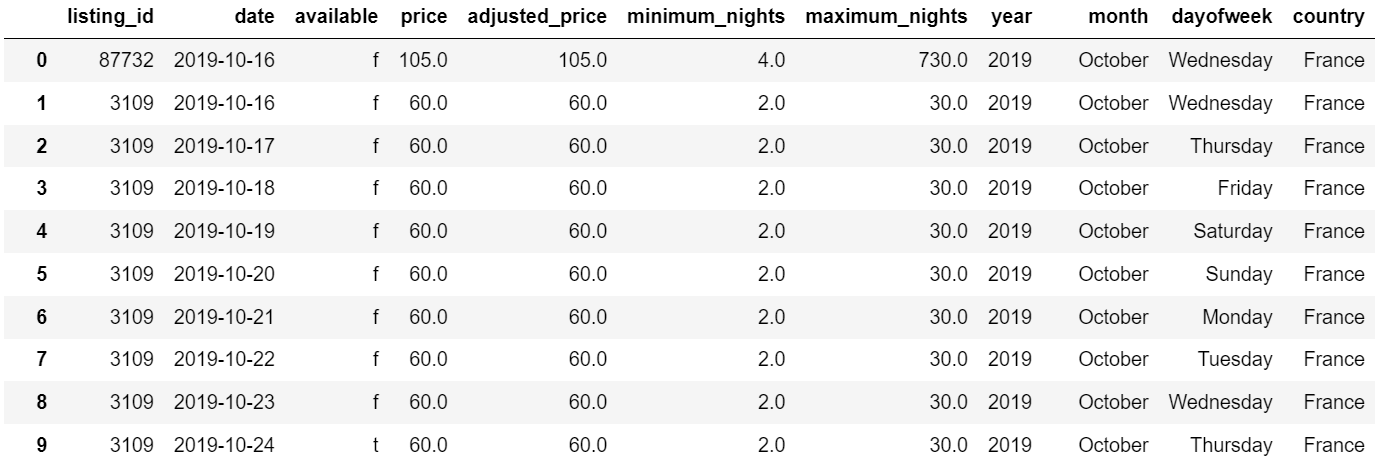



## Data Quality

When loading a dataset, it is important to ensure that the data is complete and accurate. One common issue with datasets is the presence of missing values, which can occur for a variety of reasons such as data entry errors, incomplete records, or missing information. To address this, it is important to check for missing values when loading the data.

Below, we provide a visualization of the missing values in the calendar data.

In [3]:
# Define the path to the source files
file_plots = '/mnt/processed/private/msds2023/cpt1/airbnb_plots/'

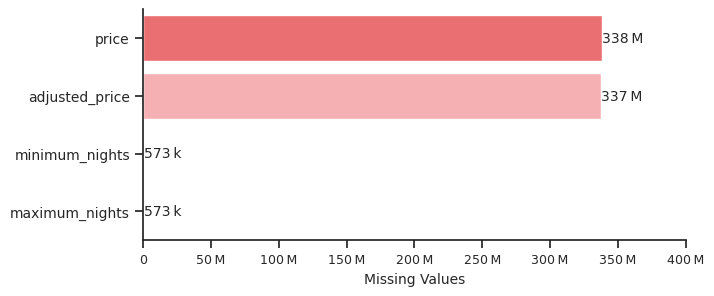

In [4]:
# Read the processed file for plotting
null_df = ps.read_csv(file_plots+'null_df').to_pandas()

# Plot the visualization
ax = sns.barplot(data=null_df, x='Missing Values', y='Columns',
                 figure=plt.figure(figsize=(7, 3), dpi=100))
ax.set(xlim=(0, 4e8))

# Customize labels and ticklabels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel('Missing Values', fontsize=10)
ax.set_ylabel('', fontsize=10)

# Format with engineering formatter
formatter1 = EngFormatter(places=0, sep="\N{THIN SPACE}")
ax.xaxis.set_major_formatter(formatter1)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt=formatter1, fontsize=10)

<center>Figure 3. Columns with Missing Values</center>

To tackle this problem, we will perform `missing value imputation` through `median imputation`. This is because median imputation is a more robust method to handle outliers than `mean imputation`, as it is not influenced by extreme values.

To demonstrate that we have successfully resolved the issue, we will visualize the missing values per column. If there are no more missing values, we should expect a blank plot.

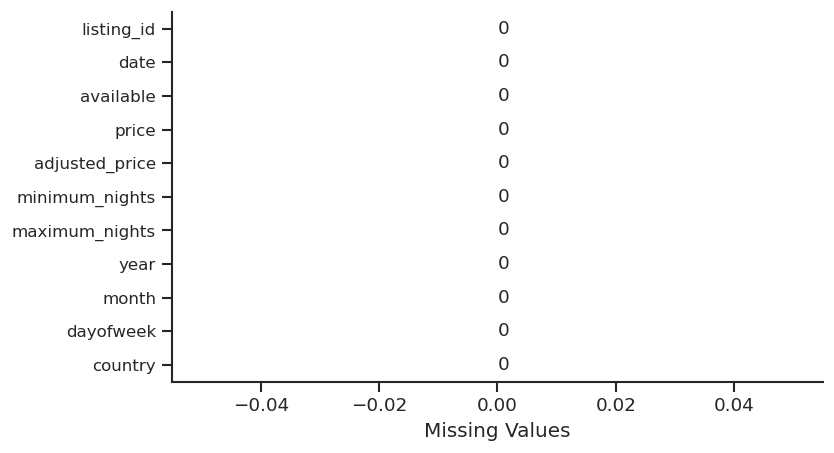

In [5]:
# Read the processed file for plotting
null_df_cleaned = ps.read_csv(file_plots+'null_df_cleaned').to_pandas()

# Plot the visualization
ax = sns.barplot(data=null_df_cleaned, x='Missing Values', y='Columns',
                figure=plt.figure(figsize=(7, 4)))

# Remove ylabel
ax.set(ylabel='')

# Add data labels
for i in ax.containers:
    ax.bar_label(i,)

<center>Figure 4. Columns with no Missing Values</center>

To maintain data integrity, we need to verify if all columns are in the correct datatypes, which should adhere to the following:

- `listing_id`: integer
- `date`: datetime
- `available`: string
- `price`: float
- `adjusted_price`: float
- `minimum_nights`: float
- `maximum_nights`: float
- `year`: integer
- `month`: string
- `dayofweek`: string

In [6]:
# Read and display the processed file for plotting
df_info = ps.read_csv(file_plots+'infoframe').to_pandas()
df_info

,#,Column,Non-Null,Count,Dtype
0,3,price,7914999048,non-null,float64
1,4,adjusted_price,7914999048,non-null,float64
2,5,minimum_nights,7914999048,non-null,float64
3,0,listing_id,7914999048,non-null,int32
4,1,date,7914999048,non-null,datetime64[ns]
5,2,available,7914999048,non-null,object
6,6,maximum_nights,7914999048,non-null,float64
7,7,year,7914999048,non-null,int32
8,8,month,7914999048,non-null,object
9,9,dayofweek,7914999048,non-null,object


<center>Table 4. Datatypes of Columns</center>

In total, the dataset used has around 7.91B of rows and 11 columns.

In [7]:
# Read and display the processed file for plotting
df_info = ps.read_csv(file_plots+'shapeframe').to_pandas()
df_info

,Rows,Columns
0,7914999048,11


Table 5. Shape of Final Data

## Global Temporal Trends Analysis

### 1. How did the prices change over the years? Is there a notable change due to external factors such as the pandemic?

**2019 to 2020:** The average price increased from \\$133.06 in 2019 to \\$134.47 in 2020, indicating a modest increase of \\$1.41 or approximately 1.1\%. This period includes the beginning of the COVID-19 pandemic, which started affecting travel and accommodations around the world in early 2020.

**2020 to 2021:** The average price continued to rise from \\$134.47 in 2020 to \\$137.10 in 2021, representing an increase of \\$2.63 or approximately 2\%. This period includes a significant portion of the pandemic, where travel restrictions and uncertainties might have impacted the demand and pricing of Airbnb accommodations.

**2021 to 2022:** The most notable increase occurred from 2021 to 2022, with the average price rising from \\$137.10 to \\$143.91, showing an increase of \\$6.81 or approximately 5\%. This period coincides with the gradual recovery from the pandemic as travel restrictions were eased and demand for accommodations started to rebound.

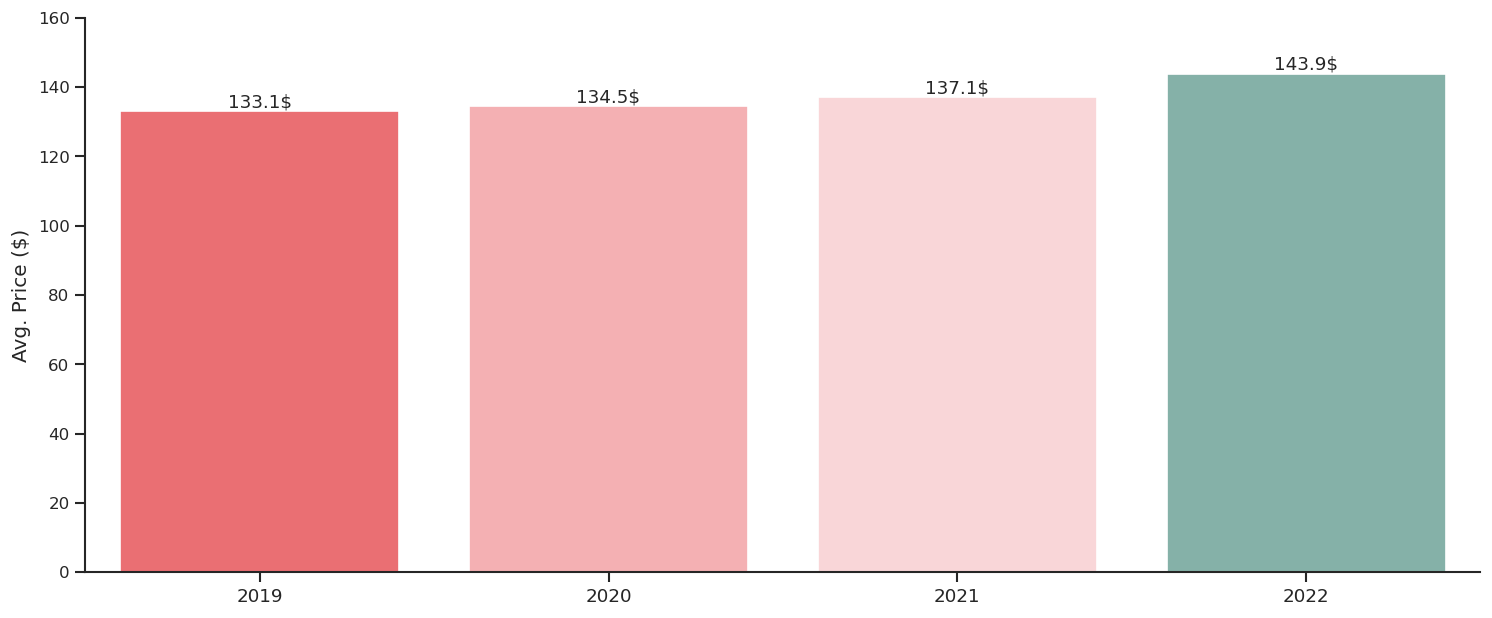

In [8]:
# Read the processed file for plotting
df_quest_1 = ps.read_csv(file_plots+'df_quest_1').to_pandas()

# Plot data for visualization
ax = sns.barplot(data=df_quest_1, x='year', y='price',
                figure=plt.figure(figsize=(15, 6), dpi=120))

# Customize parameters of plot
ax.set(ylim=(0, 160))
ax.set(xlabel='', ylabel='Avg. Price ($)')

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f$')

<center>Figure 5. Yearly Airbnb Average Prices </center>

### 2. How did the supply of listings change over the years?

**2019 to 2020:** The number of average Airbnb listings increased from approximately 19.37 million in 2019 to around 22.70 million in 2020. This represents a growth of approximately 3.33 million listings or around 17.2%. It's important to note that the COVID-19 pandemic significantly affected travel and tourism worldwide, leading to travel restrictions, lockdowns, and reduced travel demand during 2020. Despite these challenges, the data suggests that the number of Airbnb listings continued to grow, although possibly at a slower rate compared to previous years.

**2020 to 2021:** The number of listings further increased from around 22.70 million in 2020 to approximately 25.96 million in 2021, showing an additional growth of approximately 3.26 million listings or around 14.4%. This period includes a substantial portion of the pandemic, with various restrictions and uncertainties impacting travel and accommodations. The fact that the number of listings continued to grow during this time indicates that hosts remained active on the platform, potentially adapting to changing travel patterns such as increased interest in domestic or local stays as people transitioned to spending more time indoors such as having "staycations", or working from home.

**2021 to 2022:** From 2021 to 2022, the number of listings increased from around 25.96 million to approximately 27.73 million, indicating a smaller growth of approximately 1.77 million listings or around 6.8%. This period reflects the ongoing effects of the pandemic, including potential travel restrictions and evolving travel behaviors. The growth rate in listings during this period might have been influenced by factors such as increased vaccination rates, easing of restrictions, and a gradual recovery in travel demand.

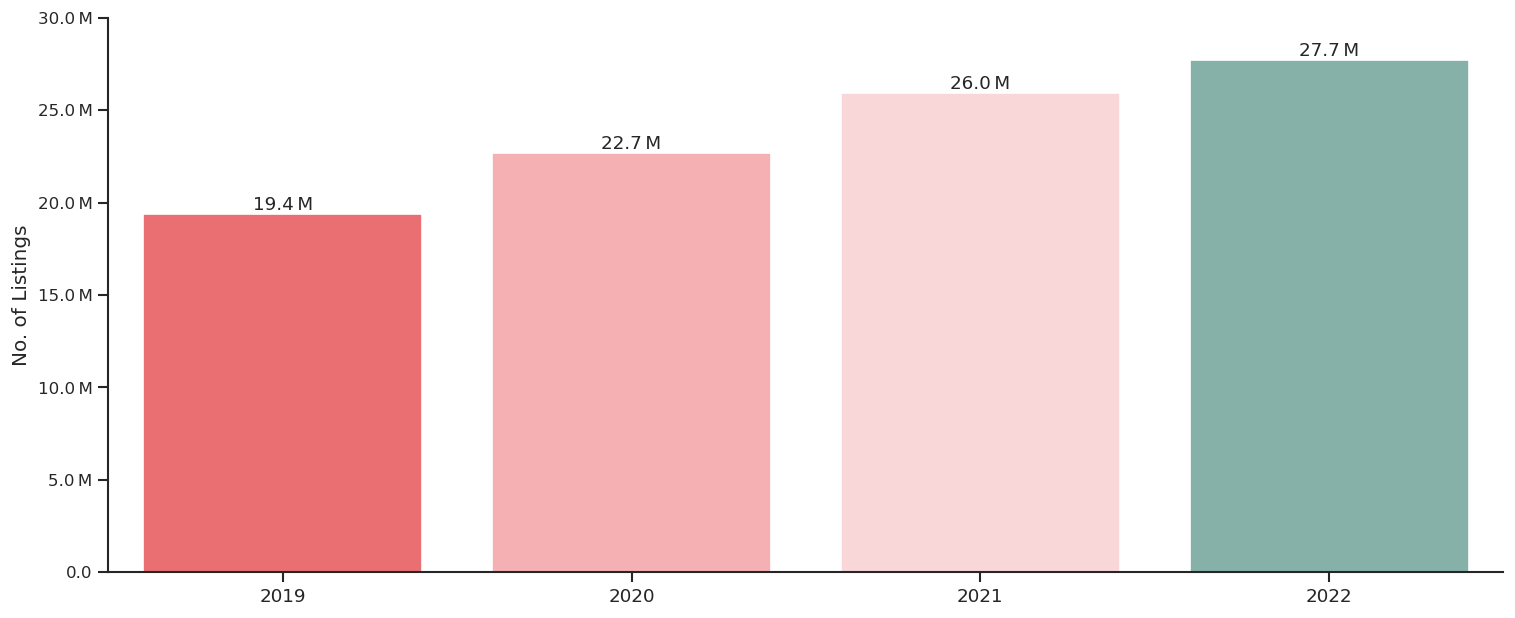

In [9]:
# Read the processed file for plotting
df_quest_2 = ps.read_csv(file_plots+'df_quest_2').to_pandas()

# Plot data for visualization
ax = sns.barplot(data=df_quest_2, x='year', y='listings',
                 figure=plt.figure(figsize=(15, 6), dpi=120))

# Customize parameters of plot
ax.set(ylim=(0, 3e7))
ax.set(xlabel='', ylabel='No. of Listings')

# Format with engineering formatter
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")
ax.yaxis.set_major_formatter(formatter1)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt=formatter1)


<center>Figure 6. Yearly Airbnb Supply of Listings</center>

### 3. How did the demand for airbnb change over the years?

**Fluctuating demand:** The demand for Airbnb listings, as indicated by the ratio of listings booked to total listings available, has shown fluctuations over the years. In 2019, approximately 11.34% of the total available listings were booked. The ratio doubled in 2020, with 22.62% of the listings booked. However, in 2021, the demand decreased to 17.10% of the available listings and further dropped to only 3.08% in 2022.


**Market adjustments:** The surge in demand during 2020, amidst the pandemic, may appear counterintuitive given the prevailing inclination for people to stay at home rather than embark on vacations. However, this period witnessed widespread quarantine measures and hotels operating at full capacity, prompting Airbnb to accommodate guests seeking quarantine stays. Consequently, there was a notable increase in demand for Airbnb listings.

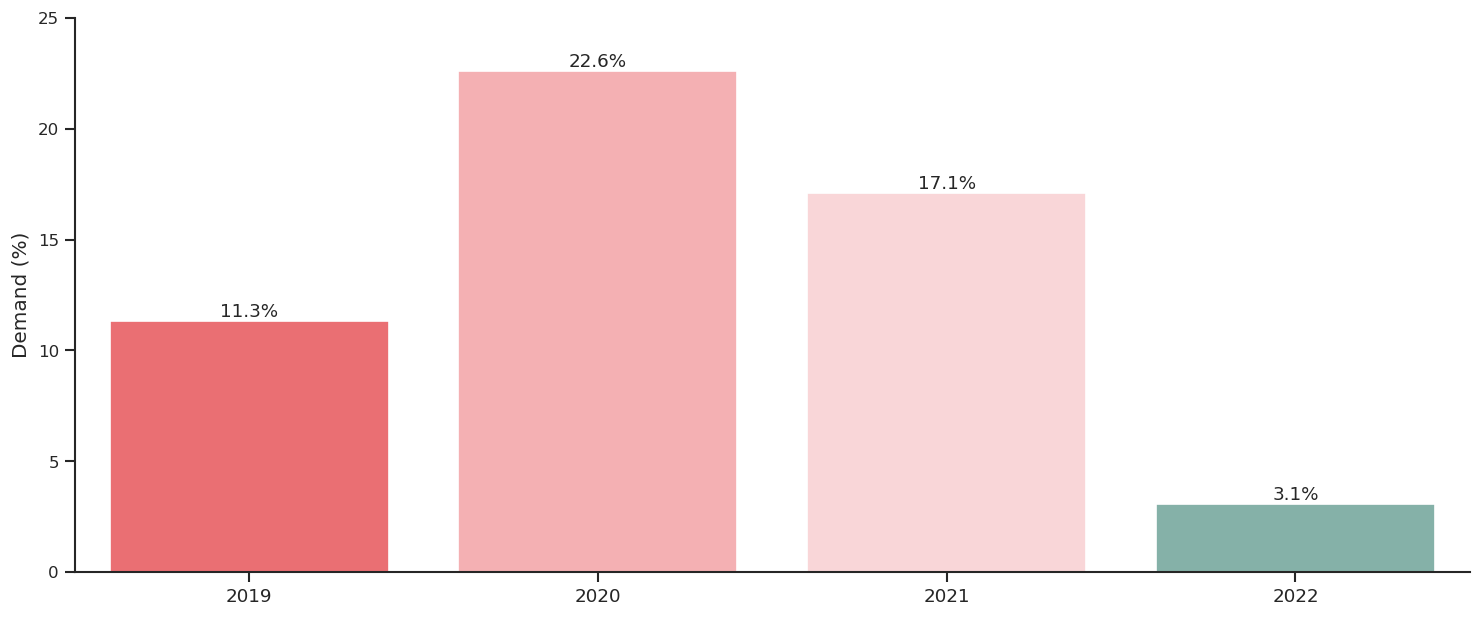

In [10]:
# Read the processed file for plotting
df_quest_3 = ps.read_csv(file_plots+'df_quest_3').to_pandas()

# Convert decimal to percentage
df_quest_3['demand_perc'] = df_quest_3.demand*100

# Plot data for visualization
ax = sns.barplot(data=df_quest_3, x='year', y='demand_perc',
                 figure=plt.figure(figsize=(15, 6), dpi=120))

# Customize parameters of plot
ax.set(ylim=(0, 25))
ax.set(xlabel='', ylabel='Demand (%)')

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%')

<center>Figure 7. Yearly Airbnb Demand of Listings</center>

### 4. How does the price differ for short- vs. long-term stays?

**Price comparison:** The data suggests that, on average, short-term stays on Airbnb have a higher price per night compared to long-term stays. The average price per night for short-term stays is \\$136.30, whereas, for long-term stays, it is $128.92. This indicates that, typically, short-term stays are priced slightly higher than long-term stays.

**Flexibility vs. commitment**: Short-term stays usually provide more flexibility in terms of duration, allowing guests to book for a few days or weeks. These shorter stays often command higher prices due to the added convenience and flexibility they offer. Long-term stays, on the other hand, require a more significant commitment from guests, often spanning several months. As a result, long-term stays tend to have slightly lower nightly rates as an incentive for guests to commit to an extended booking.

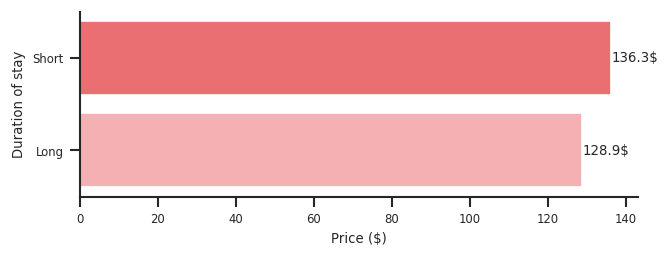

In [11]:
# Read the processed file for plotting
df_quest_4 = ps.read_csv(file_plots+'df_quest_4').to_pandas()

# Plot data for visualization
ax = sns.barplot(data=df_quest_4, y='term', x='price',
                 figure=plt.figure(figsize=(6, 2)))

# Customize parameters of plot
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
ax.set_xlabel('Price ($)', fontsize=8)
ax.set_ylabel('Duration of stay', fontsize=8)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f$', fontsize=8)

<center>Figure 8. Price difference for long-term and short-term stay</center>

### 5. Does month affect the prices? When is the best time to book?

**Monthly price variations:** The data suggests that the average price per night of Airbnb listings varies across different months. While the variations are relatively small, there are some fluctuations observed throughout the year. For example, the average prices range from \\$132.39 in November to $140.59 in August.

**Seasonal influences:** Month-to-month price variations can be influenced by seasonal factors, such as tourist seasons, holidays, or local events. Higher demand during peak travel seasons or popular holiday periods may lead to increased prices, while periods of lower demand might result in more affordable rates. Analyzing the specific factors driving these variations would provide deeper insights into the best time to book.

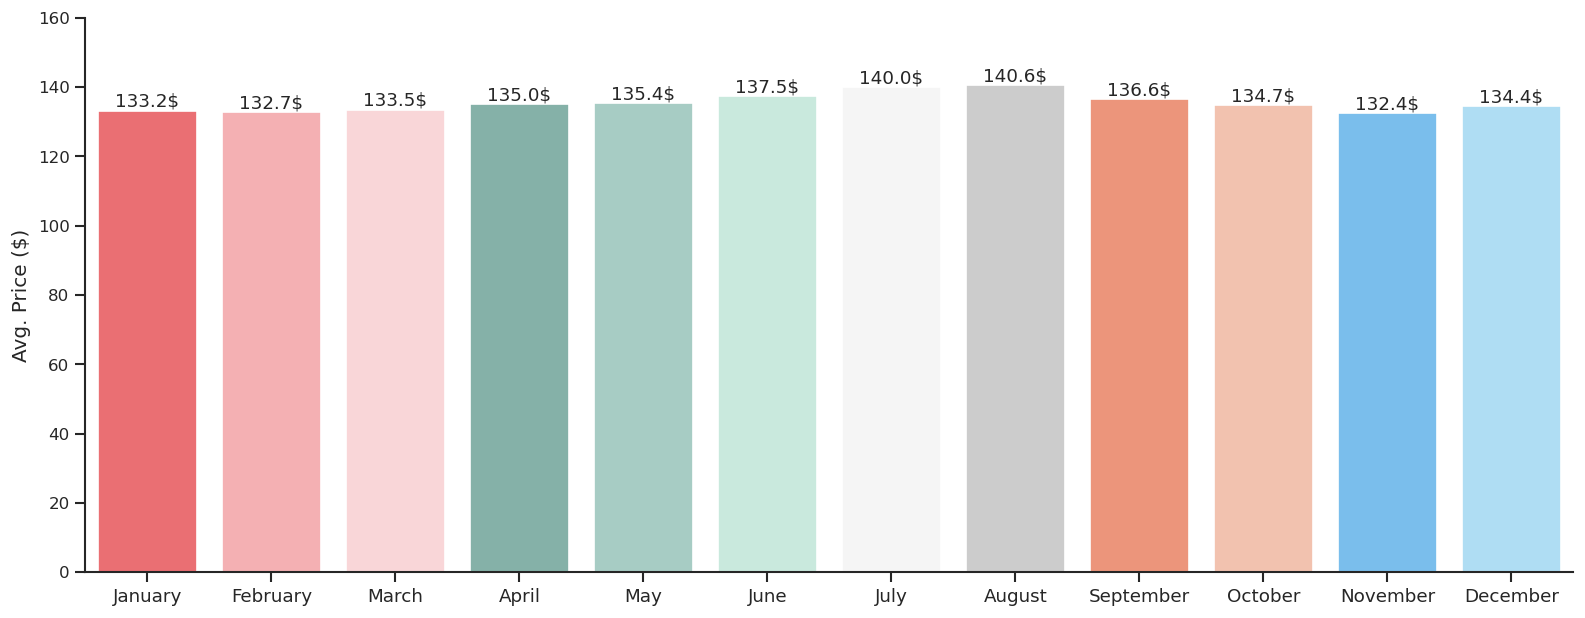

In [12]:
# Read the processed file for plotting
df_quest_5 = ps.read_csv(file_plots+'df_quest_5').to_pandas()

# Arrange month in chronological order
df_quest_5 = df_quest_5.loc[[3, 2, 4, 8, 6, 9, 0, 7, 11, 5, 1, 10]]

# Plot data for visualization
ax = sns.barplot(data=df_quest_5, x='month', y='price')

# Customize parameters of plot
ax.set(ylim=(0, 160))
ax.set(xlabel='', ylabel='Avg. Price ($)')

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f$')


<center>Figure 9. Monthly price variations</center>

### 6. Does day of week affect the prices? When is the best time to book?

**Day of the week price variations:** The data suggests that the average price per night of Airbnb listings varies slightly depending on the day of the week. While the variations are relatively small, there are some fluctuations observed throughout the week. For example, the average prices range from \\$133.88 on Tuesday to \\$138.96 on Saturday.

**Weekday vs. weekend pricing:** The data indicates that prices tend to be slightly higher during the weekend (Friday and Saturday) compared to weekdays (Sunday to Thursday). This pattern may be influenced by increased demand for accommodation during weekends when more people are likely to travel or plan leisure activities.

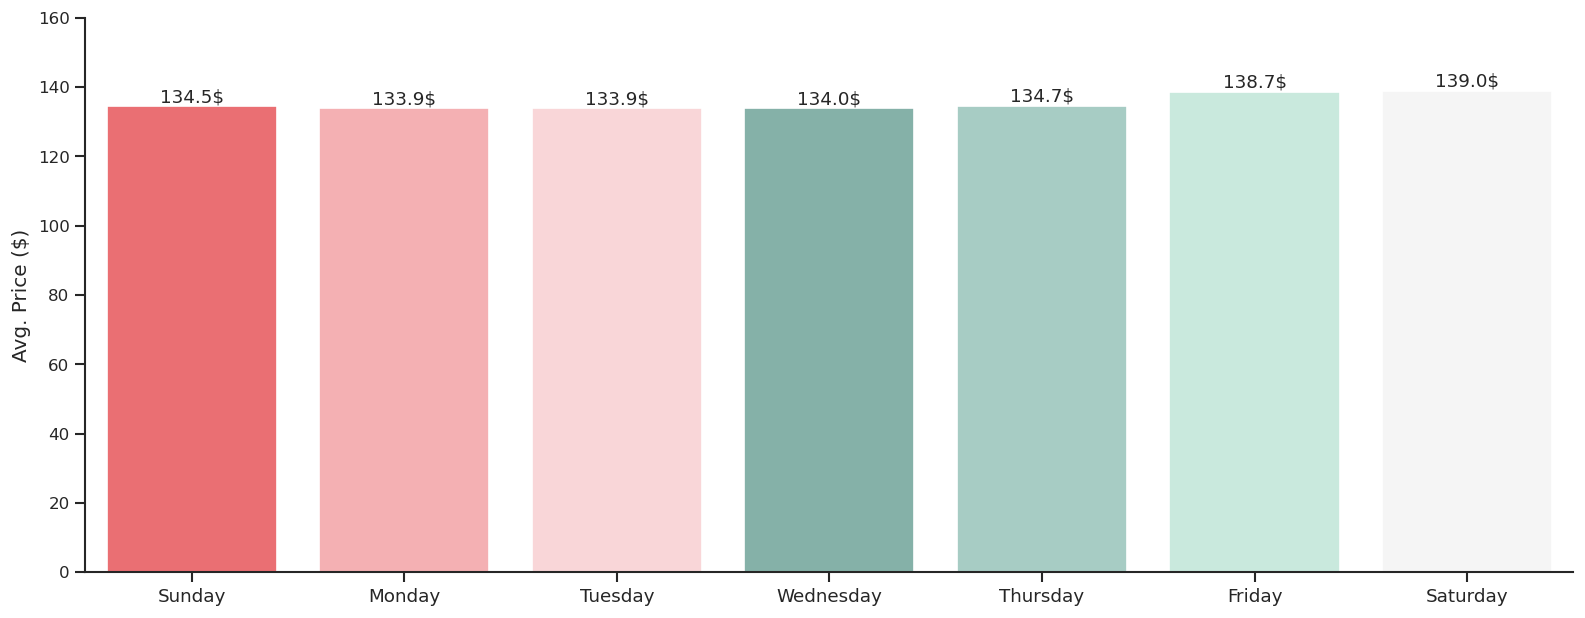

In [13]:
# Read the processed file for plotting
df_quest_6 = ps.read_csv(file_plots+'df_quest_6').to_pandas()

# Arrange month in chronological order
df_quest_6 = df_quest_6.loc[[6, 5, 1, 0, 3, 2, 4]]

# Plot data for visualization
ax = sns.barplot(data=df_quest_6, x='dayofweek', y='price')

# Customize parameters of plot
ax.set(ylim=(0, 160))
ax.set(xlabel='', ylabel='Avg. Price ($)')

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f$')

<center>Figure 10. Day of the week price variations</center>

### 7. What month is more in demand?

**Monthly demand variations:** The data reveals the number of listings booked per month, showcasing sporadic patterns in demand. Upon closer examination, it becomes evident that the months with the highest demand coincide with the holiday break, specifically December and January.

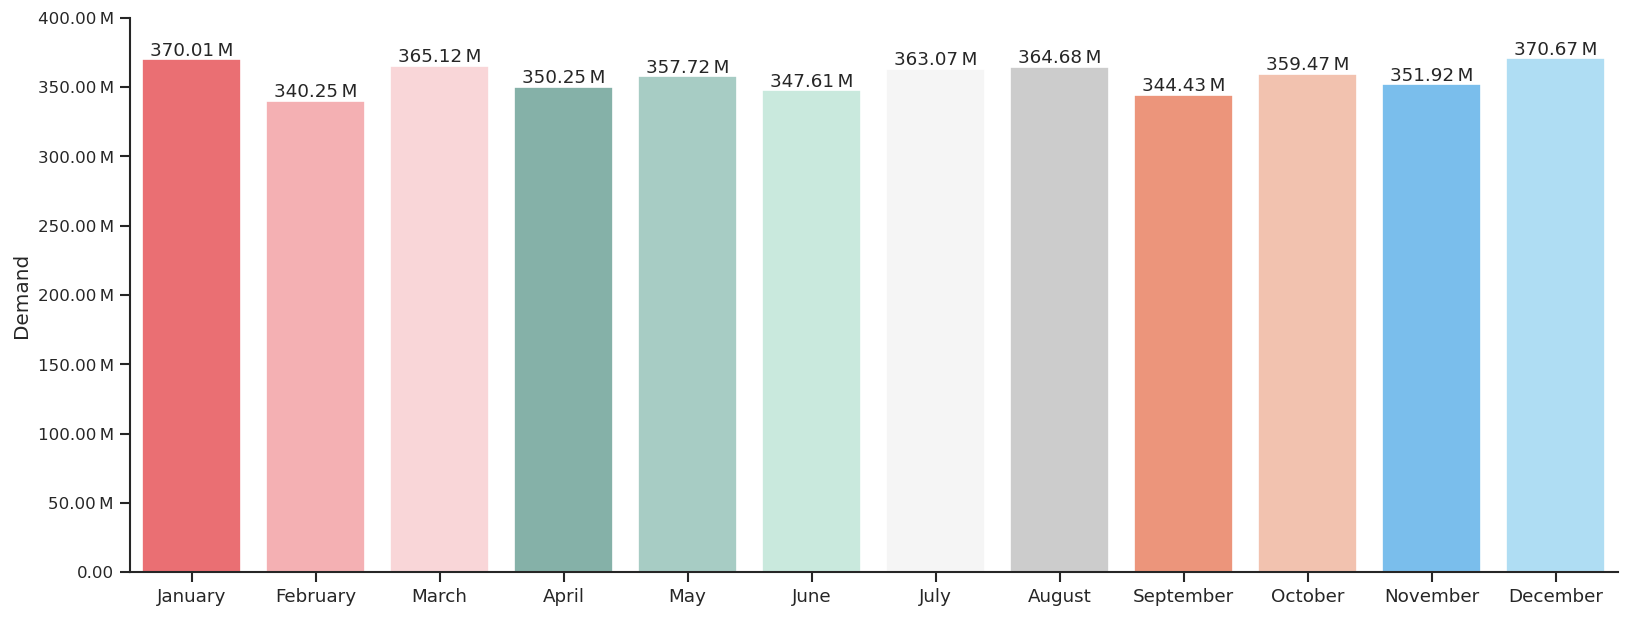

In [14]:
# Read the processed file for plotting
df_quest_7 = ps.read_csv(file_plots+'df_quest_7').to_pandas()

# Arrange month in chronological order
df_quest_7 = df_quest_7.loc[[3, 2, 4, 8, 6, 9, 0, 7, 11, 5, 1, 10]]

# Plot data for visualization
ax = sns.barplot(data=df_quest_7, x='month', y='count')

# Customize parameters of plot
ax.set(ylim=(0, 4e8))
ax.set(xlabel='', ylabel='Demand')

# Format with engineering formatter
formatter1 = EngFormatter(places=2, sep="\N{THIN SPACE}")
ax.yaxis.set_major_formatter(formatter1)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt=formatter1)


<center>Figure 11. Monthly demand variations</center>

### 8. What day of week is more in demand?

**Day of Week demand variations:** Upon analyzing the data depicting the number of listings booked per day of the week, a minimal variation can be observed. However, upon closer inspection, it becomes apparent that the demand peaks during the weekend (Friday to Saturday), while experiencing a dip during weekdays (Sunday to Thursday).

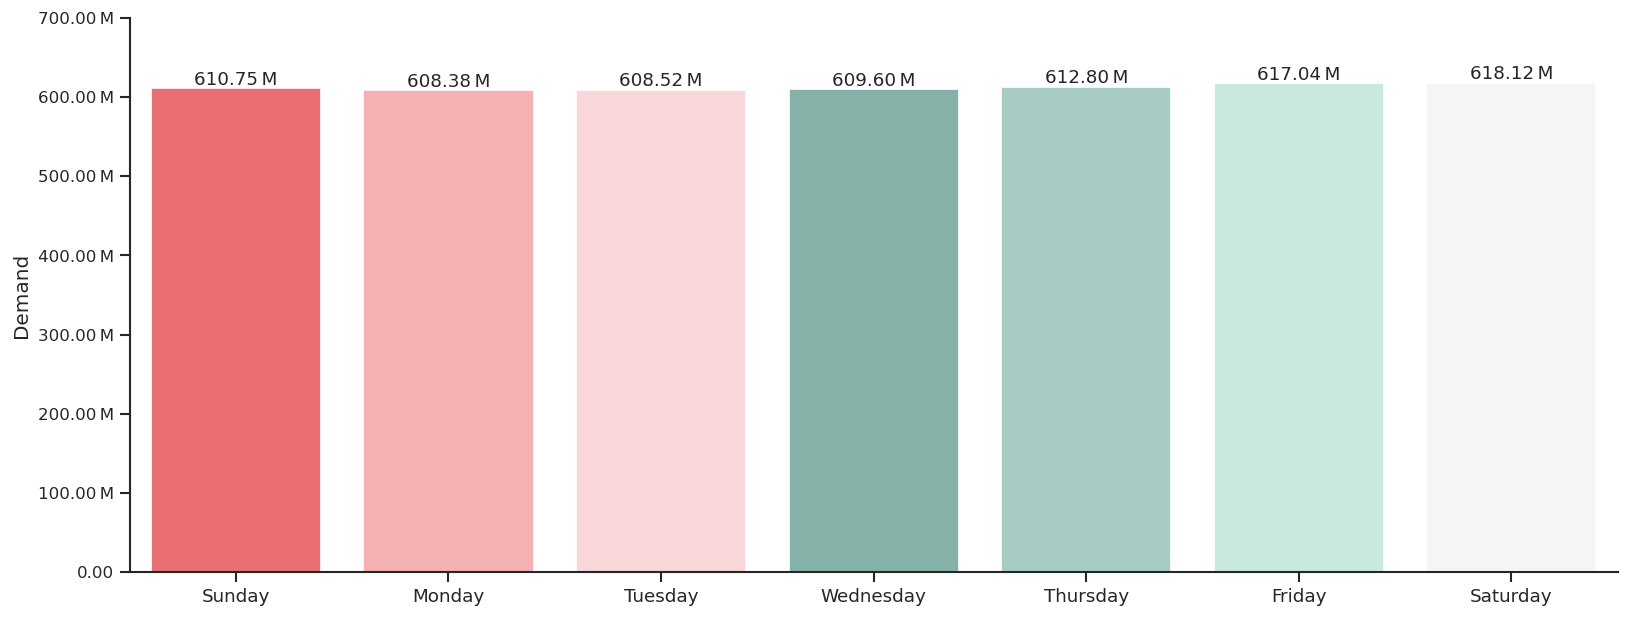

In [15]:
# Read the processed file for plotting
df_quest_8 = ps.read_csv(file_plots+'df_quest_8').to_pandas()

# Arrange month in chronological order
df_quest_8 = df_quest_8.loc[[6, 5, 1, 0, 3, 2, 4]]

# Plot data for visualization
ax = sns.barplot(data=df_quest_8, x='dayofweek', y='count')

# Customize parameters of plot
ax.set(ylim=(0, 7e8))
ax.set(xlabel='', ylabel='Demand')

# Format with engineering formatter
formatter1 = EngFormatter(places=2, sep="\N{THIN SPACE}")
ax.yaxis.set_major_formatter(formatter1)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt=formatter1)


<center>Figure 12. Day of Week demand variations</center>

## Cross-country Comparative Analysis

### 9. How does the price differ per country? Are there any notable differences?

**Notable differences:** Based on the given data, there are notable differences in average prices per country. For example, South Africa has the highest average price of \\$333.65, followed by the United States at \\$173.54. On the other hand, Belgium has the lowest average price of \\$79.39.

**Factors influencing pricing:** Several factors can influence the average price of Airbnb listings in different countries. These factors may include the local cost of living, demand for tourism, availability of accommodations, exchange rates, and economic conditions. It's important to consider these factors when interpreting the price differences between countries.

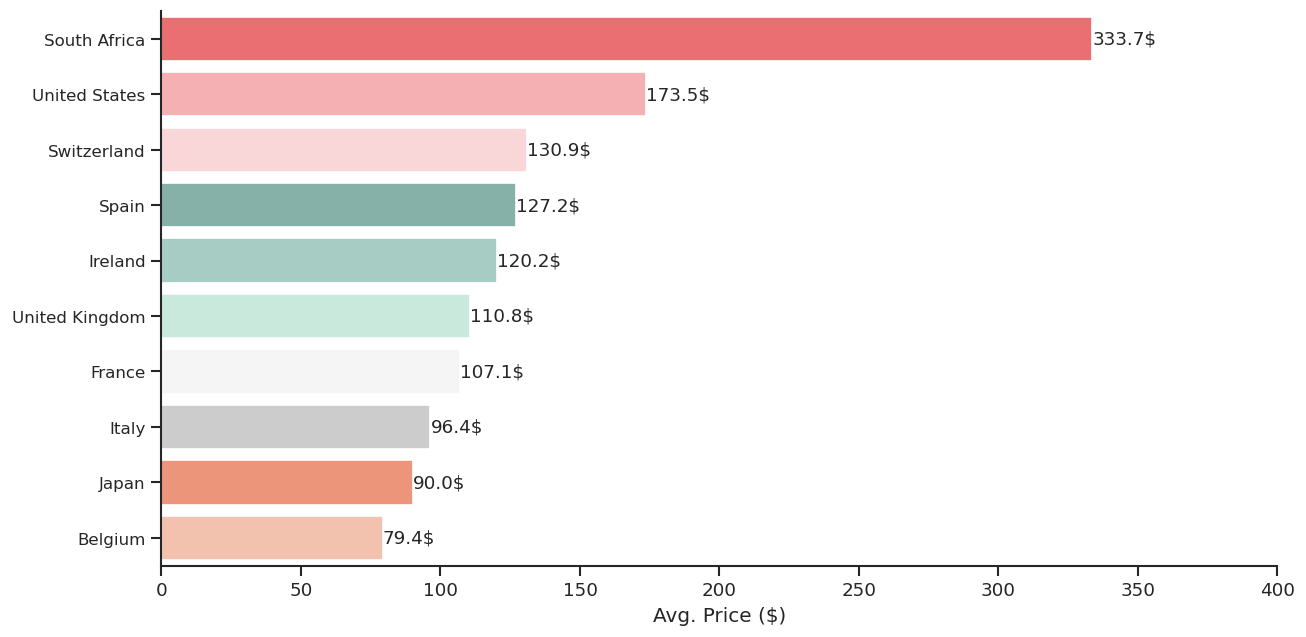

In [16]:
# Read the processed file for plotting
df_quest_10 = ps.read_csv(file_plots+'df_quest_10').to_pandas()

# Arrange price in descending order
df_quest_10 = df_quest_10.sort_values('price', ascending=False)

# Plot data for visualization
ax = sns.barplot(data=df_quest_10, x='price', y='country',
                 figure=plt.figure(figsize=(12, 6)))

# Customize parameters of plot
ax.set(xlim=(0, 400))
ax.set(xlabel='Avg. Price ($)', ylabel='')

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f$')

<center>Figure 13. Cross-country price variations</center>

### 10. How does the popularity differ per country?

**Notable differences:** Based on the given data, there are notable differences in the average number of booked listings per country. The United States has the highest average number of booked listings, with 1.42 Billion listings booked, followed by the United Kingdom and France with 702.54 Million and 701.87 Million listings booked, respectively. Switzerland has the lowest average number of booked listings, with 48.19 booked listings.

**Understanding popularity:** The average number of booked listings reflects the popularity of Airbnb accommodations in each country. Countries with higher numbers of booked listings generally indicate a higher demand for Airbnb stays.

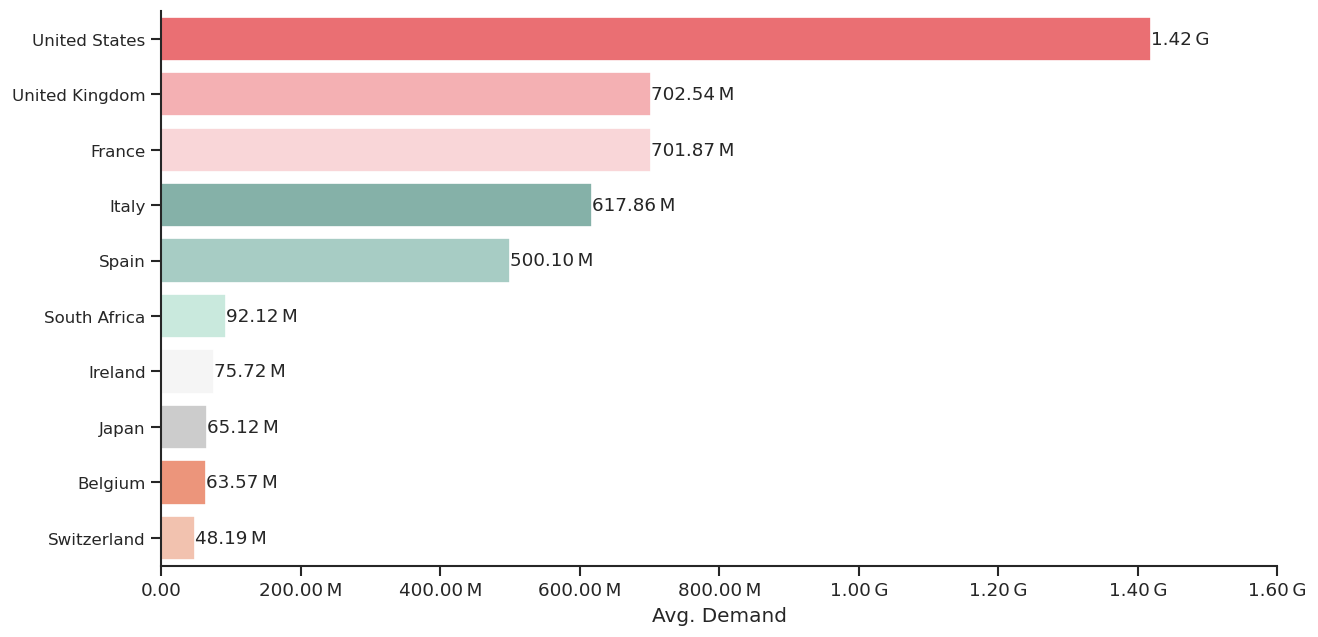

In [17]:
# Read the processed file for plotting
df_quest_11 = ps.read_csv(file_plots+'df_quest_11').to_pandas()

# Arrange count in descending order
df_quest_11 = df_quest_11.sort_values('count', ascending=False)

# Plot data for visualization
ax = sns.barplot(data=df_quest_11, x='count', y='country',
                 figure=plt.figure(figsize=(12, 6)))

# Customize parameters of plot
ax.set(xlim=(0, 1.6e9))
ax.set(xlabel='Avg. Demand', ylabel='')

# Format with engineering formatter
formatter1 = EngFormatter(places=2, sep="\N{THIN SPACE}")
ax.xaxis.set_major_formatter(formatter1)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt=formatter1)

<center>Figure 14. Cross-country popularity variations</center>

### 11. How does the supply differ per country?

**Notable differences:** Based on the given data, there are notable differences in the average number of available listings per country. The United States has the highest average number of available listings, with 2.54 Billion listings, followed by Italy and the United Kingdom with 1.70 Billion and 1.06 Billion listings, respectively. Switzerland has the lowest average number of available listings, with 82.33 Million listings.

**Understanding market size:** The average number of available listings reflects the size of the market and the number of Airbnb accommodations in each country. Countries with higher numbers of available listings generally indicate a larger supply of Airbnb stays.

**Factors influencing supply:** Several factors can influence the supply of listings in different countries. Factors such as the popularity of destinations, local regulations, housing market conditions, the density of accommodations, and the interest of hosts in listing their properties on Airbnb can impact the supply of listings.

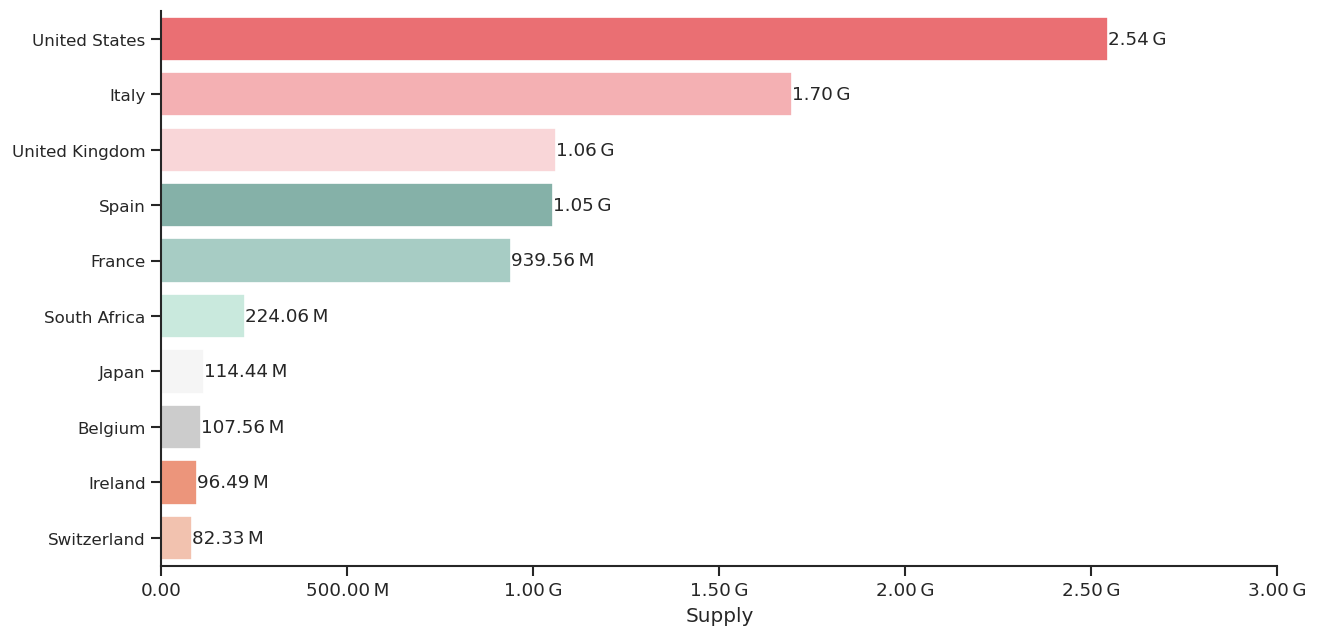

In [18]:
# Read the processed file for plotting
df_quest_12 = ps.read_csv(file_plots+'df_quest_12').to_pandas()

# Arrange count in descending order
df_quest_12 = df_quest_12.sort_values('count', ascending=False)

# Plot data for visualization
ax = sns.barplot(data=df_quest_12, x='count', y='country',
                figure=plt.figure(figsize=(12, 6)))

# Customize parameters of plot
ax.set(xlim=(0, 3e9))
ax.set(xlabel='Supply', ylabel='')

# Format with engineering formatter
formatter1 = EngFormatter(places=2, sep="\N{THIN SPACE}")
ax.xaxis.set_major_formatter(formatter1)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt=formatter1)


<center>Figure 15. Cross-country market size variations</center>

### 12. Which countries prefer short- vs. long-term stay?

**Common preference for long-term stays:** The data suggests that the countries listed tend to prioritize long-term stays in Airbnb accommodations. This preference may be influenced by various factors such as extended travel, relocation, work assignments, or longer vacation durations.

**Cultural and market factors:** The preference for long-term stays can be influenced by cultural norms, rental market dynamics, and the availability of suitable accommodations for extended periods. Factors such as the presence of corporate rentals, the popularity of longer vacations or sabbaticals, and the local housing market conditions can contribute to this preference.

In [19]:
# Read and display the processed file for plotting
df_quest_13 = ps.read_csv(file_plots+'df_quest_13').to_pandas()
display(df_quest_13)


,country,preference
0,France,Long-Term
1,Italy,Long-Term
2,Spain,Long-Term
3,United Kingdom,Long-Term
4,United States,Long-Term
5,Belgium,Long-Term
6,South Africa,Long-Term
7,Ireland,Long-Term
8,Switzerland,Long-Term
9,Japan,Long-Term


Table 6. Cross-country duration of stay preference

### 13. Can we group the countries based on prices and popularity?

The countries were separated based on whether their average price and popularity is above or below the global average of $136.9 and 428.5G, respectively. As seen in the figure below, the countries can be grouped into 4:

1. **High Popularity, High Price (Q1)**
- The United States stands out as the country where both the average price and popularity of its Airbnb listings are above the global average. As shown in the previous items, this could be attributed to higher market demand, economic factors such as higher income levels and people's willingness to pay premiums for accommodation, and the competitive supply of listings driving prices upward.


2. **Low Popularity, High Price (Q2)**
- On the opposite side of the spectrum, South Africa stands out as the country where the average price of its Airbnb listing is above the global average, while the average popularity is below it. The expensive prices could be attributed to unique market dynamics driven by a diverse tourism industry that provides luxury accommodations and unique offerings for a niche market. On the other hand, the lower popularity could be influenced by competitive alternatives and regional differences. The popularity of tourist spots may be offset by the presence of less-visited or rural areas that experiences lower demand.

3. **Low Popularity, Low Price (Q3)**
- Switzerland, Ireland, Japan, and Belgium belong to the group of countries with below-average prices and popularity for Airbnb listings. This can indicate an emerging travel destination and present a good potential market for business owners to explore. 

4. **High Popularity, Low Price (Q4)**
- Spain, United Kingdom, Italy, and France are countries with Airbnb listings that have below-average prices but above-average popularity. This combination indicates a good value for customers and suggests that these destinations are ideal places to consider for travel. 

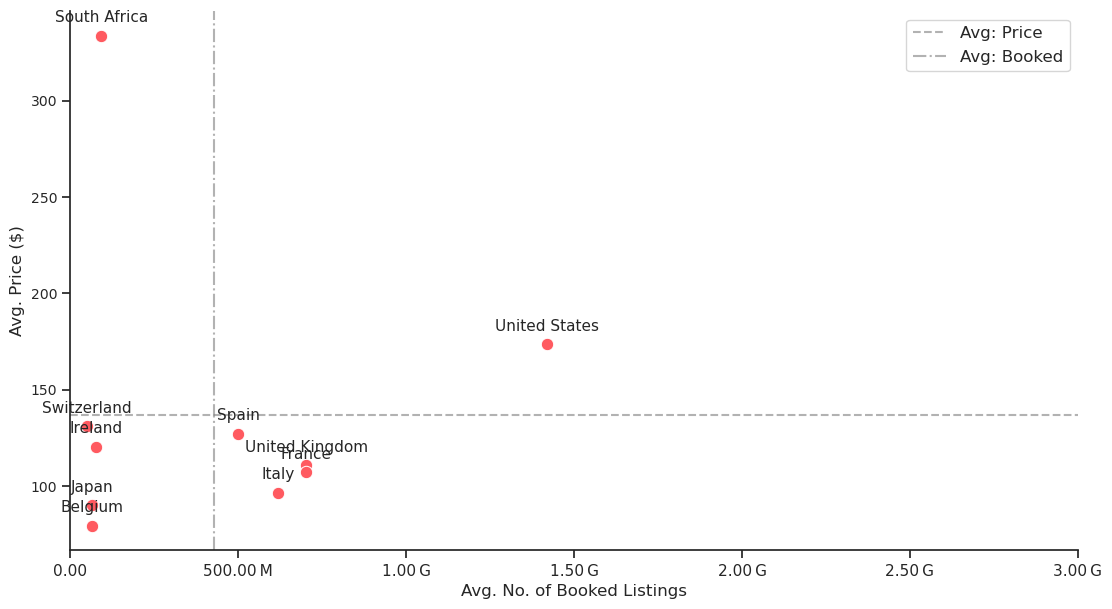

In [20]:
# Merge dataframe 10 and dataframe 11
df_quest_14 = (df_quest_10[['country', 'price']]
                .merge(df_quest_11[['country', 'count']], on=['country'], how='inner')
               ).rename(columns={'price': 'avg_price', 'count': 'avg_pop'})

# Plot data for visualization
ax = sns.scatterplot(data=df_quest_14, x='avg_pop', y='avg_price',
                     figure=plt.figure(figsize=(13, 7), dpi=100),
                     s=80)

# Customize parameters of plot
ax.set(xlim=(0, 3e9))
ax.set(xlabel='Avg. No. of Booked Listings', ylabel='Avg. Price ($)')

# Format with engineering formatter
formatter1 = EngFormatter(places=2, sep="\N{THIN SPACE}")
ax.xaxis.set_major_formatter(formatter1)

# Add broken vertical and horizontal line for axis division
plt.axhline(y=df_quest_14.mean().avg_price, color = 'grey', linestyle = '--',
            alpha=0.6, label='Avg: Price')
plt.axvline(x=df_quest_14.mean().avg_pop, color = 'grey', linestyle = '-.',
            alpha=0.6, label='Avg: Booked')

# Add data labels
for label, x, y, in zip(df_quest_14.country, df_quest_14.avg_pop, df_quest_14.avg_price):
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')

# Add legends
plt.legend();

<center>Figure 16. Grouping Countries on Average Price and Popularity</center>

***
<h1 style="color: #FF5A60"><b>VII. Results & Discussion</b></h1>

This section serves as a valuable extension of the data exploration section in this notebook. Its primary objective is to address the problem statement, while the discussions within the data exploration section specifically target the formulated questions designed to gain insightful perspectives from the inside Airbnb calendar data.

**Temporal trends in prices, availability, and demand**

During the observed period, 2019-2020 had the lowest average price increase due to the COVID-19 pandemic and travel restrictions. However, there was a gradual increase in subsequent years, with a 2% increase in 2020-2021 and a further rise to 6.8% in 2021-2022. These numbers suggest global recovery and relaxation of travel restrictions, leading to a phenomenon known as 'revenge travel' [4]. This trend is also reflected in the Airbnb market, where the number of listed homes decreased from 17.2% in 2020 to 14.4% in 2021 and 6.8% in 2022. Despite the pandemic, 2020 had the highest percentage of occupied listings, indicating that essential travelers and staycations may have contributed to the demand.

**Variations in prices, availability, and demand by country**

The global Airbnb market can be divided into four categories based on price and popularity. The United States stands out with both high popularity and high prices, driven by strong market demand, economic factors, and competition. South Africa, on the other hand, has higher prices but low popularity due to unique market dynamics and regional differences. Switzerland, Ireland, Japan, and Belgium come with low prices and low popularity indicating emerging travel destinations with potential market opportunities. Finally, Spain, United Kingdom, Italy, and France provide a combination of high popularity and low prices, making them attractive options for travelers seeking good value.

***
<h1 style="color: #FF5A60"><b>VIII. Conclusion</b></h1>

There are several factors influencing the price, availability, and demand of Airbnb listings. Observations in this project highlight the possible impact of the pandemic, the recovery and relaxation of travel restrictions over time, and the varying market dynamics across different countries.

Based on the temporal trends, people are expected to travel more moving forward as "revenge travel", "staycations", and work-from-home setup becomes a trend. Despite a decrease in the number of listings over the years, the demand for it remained and even increased in 2020 suggesting demand from essential travelers or potential alternatives instead of staying at home.

The price and popularity of Airbnb by country depend on economic factors, competition, and other market dynamics such as tourism trends, travel restrictions, and cultural preferences.

***
<h1 style="color: #FF5A60"><b>IX. Recommendations</b></h1>

Given the temporal and cross-country trends from our analysis, the following recommendations were gathered.

**For the customers:**

1. Take advantage of the global recovery and relaxation of travel restrictions by planning ahead of the trip to secure better prices before it continues to rise. As expected, booking trips on a weekday or off-peak month will be cheaper.

2. Explore emerging travel destinations such as Switzerland, Ireland, Japan, and Belgium that offer lower prices. This can be particularly attractive for customers seeking unique experiences and potential cost savings before these destinations become mainstream.

3. Consider popular destinations that offer good value for money such as Spain, United Kingdom, Italy, and France. These countries are good options for customers looking for well-known destinations with favorable pricing, allowing them to get the most value out of their travel experience.


**For the existing or potential Airbnb hosts:**

1. Leverage strong market demand in the United States. Capitalize on this by providing quality accommodations, unique offerings, and competitive pricing to attract guests.

2. Cater to niche markets in South Africa. Despite lower popularity, higher prices and lower competition within the country can be advantageous for hosts.

3. Tap into emerging travel destinations with low prices and popularity. Potential hosts or business owners could capitalize on this opportunity by catering to the growing demand for accommodations and services in these countries, offering distinctive offerings that satisfy the preferences of travelers seeking off-the-beaten-path experiences.

***
<h1 style="color: #FF5A60"><b>X. References</b></h1>

[1] Viswanathan, V. (2022, August 22). What The Rising Popularity Of The Rental Economy Can Tell Us About The Future Of Business. Forbes. https://www.forbes.com/sites/forbestechcouncil/2022/08/22/what-the-rising-popularity-of-the-rental-economy-can-tell-us-about-the-future-of-business/?sh=61532c39466d

[2] Jafari, K., Özduran, A., Saydam, M. (2021). Hospitality and tourism industry amid COVID-19 pandemic: voices from small Mediterranean town. International Hospitality Review. ISSN: 2516-8142. https://www.emerald.com/insight/content/doi/10.1108/IHR-07-2021-0054/full/html

[3] Sherwood, H. (2019). How Airbnb took over the world. The Guardian. Retrieved from https://www.theguardian.com/technology/2019/may/05/airbnb-homelessness-renting-housing-accommodation-social-policy-cities-travel-leisure

[4] Marcus, L. (2022, May 16). Revenge travel: How vacation vengeance became a thing. CNN. https://edition.cnn.com/travel/article/revenge-travel-explainer/index.html

[5] Guller, M. (2015). Big Data Analytics with Spark: A Practitioner's Guide to Using Spark for Large Scale Data Analysis (1st ed.). Apress.

[6] Lai, R., & Potaczek, B. (2019). Hands-On Big Data Analytics with PySpark: Analyze large datasets and discover techniques for testing, immunizing, and parallelizing Spark jobs. Packt Publishing.